In [1]:
from matplotlib import pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from collections import Counter
from sklearn import ensemble
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import re

import spacy

sns.set(rc={'figure.figsize':(12,7)}, style='whitegrid', color_codes=True)

Source = http://jmcauley.ucsd.edu/data/amazon/ 

## Challenge: Is to Build an NLP model to classify reviews or texts from Amazon as positive or negative.

In [2]:
#df =  pd.read_csv('/Users/Sri/Downloads/Amazon_Books_Review.csv')
df = pd.read_json('Amazon_Instant_Video_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400


In [4]:
df.overall.value_counts(normalize=True)

5    0.562678
4    0.227496
3    0.112778
2    0.050773
1    0.046275
Name: overall, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.5+ MB


In [6]:
# Making a subset dataframe of only the columns which are necessary for analysis.
data=df[['reviewText', 'overall']]

In [7]:
# Making a subset of the data for faster run time
data = data.sample(frac=0.1, replace=False, random_state=1)
data.reset_index(drop=True, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3713 entries, 0 to 3712
Data columns (total 2 columns):
reviewText    3713 non-null object
overall       3713 non-null int64
dtypes: int64(1), object(1)
memory usage: 58.1+ KB


In [9]:
data.head()

,reviewText,overall
0,i saw the series on TV and wasn;t too imressed...,5
1,I love police procedurals. My favorite is the ...,5
2,"Very good well written series, so sorry it di...",3
3,"One episode in, I plan to watch another. The a...",3
4,"This is a wild ride, on the one hand we've got...",5


In [10]:
#Checking for nulls
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

In [11]:
data.overall.unique()

array([5, 3, 4, 2, 1], dtype=int64)

In [12]:
# Creating outcome variable i.e review_sentiment as positive or negative
data['review_sentiment'] = np.where(data['overall'] > 3, 1, 0)

In [13]:
data.head()

,reviewText,overall,review_sentiment
0,i saw the series on TV and wasn;t too imressed...,5,1
1,I love police procedurals. My favorite is the ...,5,1
2,"Very good well written series, so sorry it di...",3,0
3,"One episode in, I plan to watch another. The a...",3,0
4,"This is a wild ride, on the one hand we've got...",5,1


In [14]:
# Making a subset dataframe of only the columns which are necessary for analysis.
data.drop('overall', inplace=True, axis=1)

Before doing any of the next steps we need to extract the reviews as positive or negative for creating features category wise.

In [15]:
all_reviews_positive=[]
all_reviews_negative=[]

for text in (data.loc[data['review_sentiment'] == 1, 'reviewText'].values):
    all_reviews_positive.append(text)
    
for text in (data.loc[data['review_sentiment'] == 0, 'reviewText'].values):
    all_reviews_negative.append(text)

In [16]:
len(all_reviews_positive)

2954

In [17]:
len(all_reviews_negative)

759

In [18]:
# Finding the length of each review for 10 rows
for i in range(10):
    print (len (data['reviewText'][i]))

341
413
110
169
861
237
505
277
1462
111


Some of them have pretty long reviews. More the words better it is for word training.

Since the size of the text is greater than 1 million, Spacy gives an error. so broken down the text into a list of strings.

### 1. Data cleaning / processing / language parsing

In [19]:
# Cleaning the texts and making the tokens ready for further processing
temp='' 
all_reviews_positive_cl = []
all_reviews_negative_cl =[]
for review in all_reviews_positive:

    for word in str.split(review):
        if word.isalpha():
            temp =temp + ' '+word.lower()
    all_reviews_positive_cl.append(temp)
    temp=''
        
for review in all_reviews_negative:
    for word in str.split(review):
        if word.isalpha():
            temp = temp + ' ' + word.lower()
    all_reviews_negative_cl.append(temp)
    temp=''

In [20]:
all_reviews_positive_cl[0]

' i saw the series on tv and too the second time around was much story line moves the characters are intriguing and the suspense is highly recommend this series to all who would enjoy horror with a great story see the first american horror is'

In [21]:
# Parsing the texts
nlp = spacy.load('en')

all_reviews_positive_list_nlp = [nlp(text) for text in all_reviews_positive_cl]
all_reviews_negative_list_nlp = [nlp(text) for text in all_reviews_negative_cl]

In [22]:
all_reviews_positive_list_tokens=[]
all_reviews_negative_list_tokens=[]
for review in all_reviews_positive_list_nlp:
    allwords = [token for token in review if not token.is_punct and not token.is_stop
                and not token.is_space and token.is_alpha]
    all_reviews_positive_list_tokens.append(allwords)
    allwords=[]
for review in all_reviews_negative_list_nlp:
    allwords = [token for token in review if not token.is_punct and not token.is_stop
                and not token.is_space and token.is_alpha]
    all_reviews_negative_list_tokens.append(allwords)
    allwords=[]

### 2. Create features using two different NLP methods: For example,  BOW and tf-idf.

### BOW feature generation

In [23]:
# Utility function to create a list of the unique adjectives which describe the
#sentiment of the review and taking the unique words here.

def bag_of_words_adject(doc):
    
    # Filter out punctuation and stop words.
    
    pos = [token.text for sent in doc.sents for token in sent if token.pos_ == 'ADJ']
               
    # Return the most common words.
    return [item[0] for item in Counter(pos).most_common(1000)]    
    
# Set up the bags.
# Another function to consolidate all words

def combine(function, text):
    temp = []
    for item in text:   
        temp.append(function(item))
    return temp

In [24]:
#Creating bags for unique words
review_positive_adject = []
review_negative_adject = []
review_positive_adject = combine(bag_of_words_adject, all_reviews_positive_list_nlp)
review_negative_adject = combine(bag_of_words_adject, all_reviews_negative_list_nlp)

#Taking the unique adjectives of positive and negative reviews
review_positive_adject = set([x for x in (review_positive_adject) for x in x])
review_negative_adject = set([x for x in (review_negative_adject) for x in x])

unique_adject1 = review_positive_adject - review_negative_adject
unique_adject2 = review_negative_adject - review_positive_adject
unique_adject = list(unique_adject1) + list(unique_adject2)
#unique_adject1 =set(unique_adject))

In [25]:
len(unique_adject) # Length of unique words found which are unique only to one group positive or negative

2161

In [26]:
#Creating dataframes for holding the features

df = pd.DataFrame(columns=['Text'])
total = all_reviews_positive_list_nlp+all_reviews_negative_list_nlp
for i, review in enumerate(total):
    df.loc[i, 'Text'] = review
df['review_sentiment'] = 0
df.loc[0:len(all_reviews_positive_list_nlp)-1, 'review_sentiment'] = 1

reviews_df = pd.DataFrame(columns=unique_adject)
reviews_df['review_text'] = df['Text']
reviews_df['review_sentiment'] = df['review_sentiment']
reviews_df.loc[:, unique_adject] = 0
reviews_df.head()

,visceral,unsuitable,arthurian,adventuresome,predatory,ballistic,causton,skeletal,slasher,easier,...,core,divorced,feeble,peaceful,midwest,avid,cynical,funniest,review_text,review_sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, saw, the, series, on, tv, and, too, the...",1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, love, police, my, favorite, is, the, sw...",1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , this, is, a, wild, on, the, one, hand, got...",1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, like, this, tv, series, which, nowadays...",1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, liked, a, girl, goes, to, a, party, and...",1


In [27]:

# Creates a data frame with features for each word in our common word set.

def bow_features(reviews_df=reviews_df, unique_adject=unique_adject):

        # Process each row, counting the occurrence of words in each sentence.
    for i, review in enumerate(reviews_df['review_text']):
       
        # Populate the row with word counts.
        for token in review:
      
            if token.text in unique_adject:
               reviews_df.loc[i, token.text] += 1

        ## This counter is just to make sure the kernel didn't hang.
        if i % 1000 == 0:
            print ("Processing row {}".format(i))
        
    print ("Done Atlast!!!")                   
    return reviews_df

review_df = bow_features()
review_df.head()

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Done Atlast!!!


,visceral,unsuitable,arthurian,adventuresome,predatory,ballistic,causton,skeletal,slasher,easier,...,core,divorced,feeble,peaceful,midwest,avid,cynical,funniest,review_text,review_sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, saw, the, series, on, tv, and, too, the...",1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, love, police, my, favorite, is, the, sw...",1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , this, is, a, wild, on, the, one, hand, got...",1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, like, this, tv, series, which, nowadays...",1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"( , i, liked, a, girl, goes, to, a, party, and...",1


In [28]:
# Splitting data into X and Y
Y = review_df['review_sentiment']
X = review_df.loc[:, ~(review_df.columns).isin(['review_sentiment', 'review_text'])]

In [29]:
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2954, 0: 759})


There is a lot of class imbalance here. Need to correct the problem before going further by over sampling and under sampling (SMOTE).

In [30]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2954, 0: 2954})


In [31]:
#Shuffle data since smote add over sampled minority samples at the end.
X = pd.DataFrame(X)
Y = pd.Series(Y)

X = X.sample(frac=1, replace=False, random_state=2)
Y = Y.sample(frac=1, replace=False, random_state=2)

X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)

In [32]:
Y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

### 3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
### 4. Assess your models using cross-validation and determine whether one model performed better.

In [33]:
def model(mod, X=X, Y=Y):
    model_object=mod
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=3)
    model_object.fit(X_train, y_train)
    print ("Model train score is %0.2f" % (model_object.score(X_train, y_train)) )
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=10)
    print ('\nCross_validation scores below :\n', score)
    print("\nMean/test accuracy: %0.2f (+/- %0.2f)\n" % (score.mean(), score.std() * 2))
    
    y_pred=model_object.predict(X_test)
  
   #Plotting the ROC-AUC curve   
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', linewidth=4,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fancybox=True, fontsize='large')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    return

In [34]:
### Naive Bayes Classifier

Model train score is 0.69

Cross_validation scores below :
 [0.58783784 0.60810811 0.60810811 0.58108108 0.54054054 0.59459459
 0.62162162 0.59863946 0.60544218 0.59183673]

Mean/test accuracy: 0.59 (+/- 0.04)



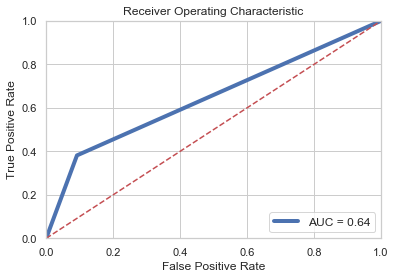

The sensitivity i.e true positives is 38.127544% 
The specificity i.e true negatives is 90.810811% 
The Type I error i.e. false negatives is 61.872456% 
The Type II error i.e. false positives is 9.189189% 


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [35]:
model(BernoulliNB())

In [36]:
### kNN Classifier

Model train score is 0.65

Cross_validation scores below :
 [0.5        0.47297297 0.53378378 0.5472973  0.56756757 0.57432432
 0.55405405 0.57142857 0.52380952 0.55102041]

Mean/test accuracy: 0.54 (+/- 0.06)



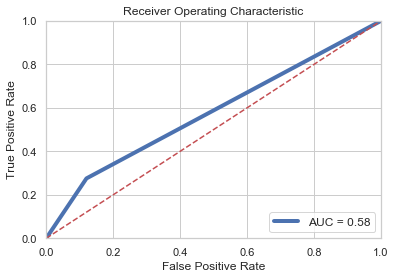

The sensitivity i.e true positives is 27.544098% 
The specificity i.e true negatives is 87.972973% 
The Type I error i.e. false negatives is 72.455902% 
The Type II error i.e. false positives is 12.027027% 


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [37]:
model(neighbors.KNeighborsClassifier(n_neighbors=5))

In [38]:
### Random Forest Classifier

C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model train score is 0.81

Cross_validation scores below :
 [0.60135135 0.62162162 0.60135135 0.60135135 0.5472973  0.58783784
 0.60810811 0.62585034 0.57142857 0.6462585 ]

Mean/test accuracy: 0.60 (+/- 0.05)



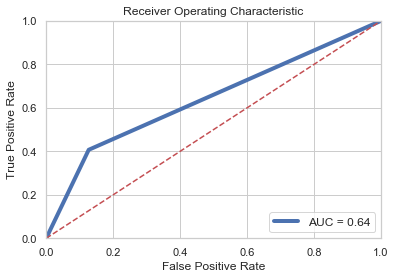

The sensitivity i.e true positives is 40.705563% 
The specificity i.e true negatives is 87.297297% 
The Type I error i.e. false negatives is 59.294437% 
The Type II error i.e. false positives is 12.702703% 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
model(ensemble.RandomForestClassifier())

In [40]:
### Logistic Regression

Model train score is 0.77

Cross_validation scores below :
 [0.66891892 0.66891892 0.63513514 0.60810811 0.62162162 0.62162162
 0.56081081 0.63945578 0.65306122 0.72108844]

Mean/test accuracy: 0.64 (+/- 0.08)



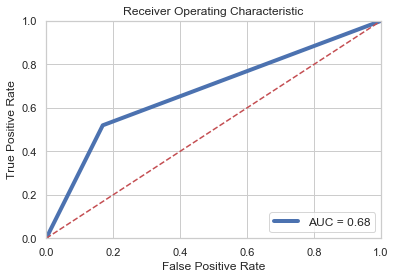

The sensitivity i.e true positives is 51.967436% 
The specificity i.e true negatives is 83.108108% 
The Type I error i.e. false negatives is 48.032564% 
The Type II error i.e. false positives is 16.891892% 


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [41]:
model(LogisticRegression(C=1e9, solver='liblinear'))

In [42]:
### Gradient Boost Classifier

Model train score is 0.65

Cross_validation scores below :
 [0.56756757 0.54054054 0.59459459 0.57432432 0.52702703 0.60135135
 0.5472973  0.60544218 0.55102041 0.5170068 ]

Mean/test accuracy: 0.56 (+/- 0.06)



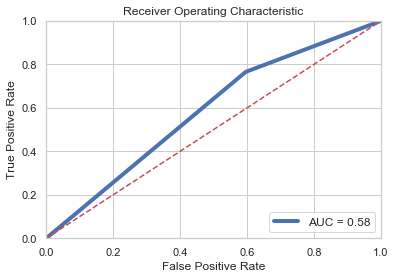

The sensitivity i.e true positives is 76.526459% 
The specificity i.e true negatives is 40.405405% 
The Type I error i.e. false negatives is 23.473541% 
The Type II error i.e. false positives is 59.594595% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [43]:
model(ensemble.GradientBoostingClassifier())

The Logistic regression gives the best AUC of 0.67. percent 64% test accuracy and also low errors compared to other models.

Now let us see how the TF-IDF does with accuracy and errors

### TF-IDF

In [44]:
#df =  pd.read_csv('/Users/Sri/Downloads/Amazon_Books_Review.csv')
df = pd.read_json('Amazon_Instant_Video_5.json', lines=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.5+ MB


In [46]:
# Making a subset dataframe of only the columns which are necessary for analysis.
data=df[['reviewText', 'overall']]

In [47]:
# Making a subset of the data for faster run time
data = data.sample(frac=0.1, replace=False, random_state=1)
data.reset_index(drop=True, inplace=True)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3713 entries, 0 to 3712
Data columns (total 2 columns):
reviewText    3713 non-null object
overall       3713 non-null int64
dtypes: int64(1), object(1)
memory usage: 58.1+ KB


In [49]:
data.head()

,reviewText,overall
0,i saw the series on TV and wasn;t too imressed...,5
1,I love police procedurals. My favorite is the ...,5
2,"Very good well written series, so sorry it di...",3
3,"One episode in, I plan to watch another. The a...",3
4,"This is a wild ride, on the one hand we've got...",5


Since the size of the text is greater than 1 million, Spacy gives an error. so broken down the text into a list of strings.

In [50]:
# Parsing the texts
nlp = spacy.load('en')

all_reviews_positive_list_doc = [ nlp(text) for text in all_reviews_positive]
all_reviews_negative_list_doc = [ nlp(text) for text in all_reviews_negative]

all_reviews_positive_list_doc[:1]

[i saw the series on TV and wasn;t too imressed. The second time around was much, much better!The story line moves effortlessly, the characters are intriguing and the suspense is superb.I highly recommend this series to all who would enjoy horror with a great story line.Also see the first American Horror Story...that is really,really good!!]

In [51]:
### 1. Data cleaning / processing / language parsing

# Cleaning the texts and making the words ready for further processing

all_reviews_list_cleaned_doc=[]
temp=''         
for review in all_reviews_positive_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''
        
for review in all_reviews_negative_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''

all_reviews_list_cleaned_doc[0]

' i saw the series on tv and too imressed the second time around was much much story line moves effortlessly the characters are intriguing and the suspense is superb i highly recommend this series to all who would enjoy horror with a great story line also see the first american horror story that is really really good'

In [52]:
def tf_idf_svd(doc):
    from sklearn.feature_extraction.text import TfidfVectorizer


    vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
    #Applying the vectorizer
    review_tfidf=vectorizer.fit_transform(doc)
    print("Number of features: %d" % review_tfidf.get_shape()[1])

    from sklearn.decomposition import TruncatedSVD
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer

    #Our SVD data reducer.  We are going to reduce the feature space.
    n = int((review_tfidf.get_shape()[1])/5)
    print ('Dimension Reduction from %d to %d' % (review_tfidf.get_shape()[1], n))
    svd= TruncatedSVD(n)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD.
    review_lsa = lsa.fit_transform(review_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("\nPercent variance captured by all components:",total_variance*100)
    reviews_by_component=pd.DataFrame(review_lsa, index=doc)

    return reviews_by_component

In [53]:
reviews_by_component = tf_idf_svd(all_reviews_list_cleaned_doc)

Number of features: 9544
Dimension Reduction from 9544 to 1908

Percent variance captured by all components: 89.87117044602914


In [54]:
#Adding review sentiment to the final dataframe with tfidf values
reviews_by_component.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

reviews_by_component['review_sentiment'] = 0
reviews_by_component.loc[0:len(all_reviews_positive_list_doc)-1, 'review_sentiment'] = 1

In [55]:
reviews_by_component.head()

,0,1,2,3,4,5,6,7,8,9,...,1899,1900,1901,1902,1903,1904,1905,1906,1907,review_sentiment
0,0.313032,-0.117873,0.144888,-0.207028,0.010515,0.111207,-0.161987,-0.034516,-0.056834,0.106840,...,0.000045,0.009204,0.003628,-0.000505,0.009967,-0.005784,0.001667,-0.006249,0.002409,1
1,0.150912,-0.048456,0.078848,0.025853,0.056999,-0.033234,-0.071333,-0.019334,0.016072,0.019514,...,-0.010459,-0.014864,0.009009,0.013337,-0.006882,-0.001994,-0.022676,-0.018623,0.017670,1
2,0.106306,-0.035666,-0.004998,-0.020258,-0.068440,0.024775,-0.011298,0.034725,0.013567,-0.018011,...,0.003294,0.003069,0.010905,0.005505,0.013701,-0.004735,0.010729,-0.013304,-0.008804,1
3,0.266267,0.072374,-0.041293,0.020490,-0.137873,-0.042805,0.010941,-0.025466,0.112133,-0.193991,...,-0.007027,0.002324,0.000318,-0.001043,-0.010286,0.013423,-0.004277,0.006052,-0.010688,1
4,0.137645,-0.083494,-0.070827,0.026686,0.103407,0.075827,-0.054038,0.101211,0.018956,-0.010538,...,-0.000478,-0.009622,0.005304,-0.020518,0.005972,-0.016634,-0.005524,-0.005521,0.012139,1


In [56]:
# To schuffle samples


reviews_by_component = reviews_by_component.sample(frac=1, replace=False, random_state=2)
reviews_by_component.reset_index(drop=True, inplace=True)

# Splitting data into X and Y
Y = reviews_by_component['review_sentiment']
X = reviews_by_component.loc[:, ~(reviews_by_component.columns).isin(['review_sentiment'])]

In [57]:
reviews_by_component.head()

,0,1,2,3,4,5,6,7,8,9,...,1899,1900,1901,1902,1903,1904,1905,1906,1907,review_sentiment
0,0.171477,-0.108976,-0.104719,0.028295,-0.004206,-0.003784,-0.008903,-0.067037,0.010015,0.004033,...,-0.020900,0.007613,-0.010660,0.006220,-0.000172,-0.002300,0.005771,-0.012946,-0.002324,0
1,0.107200,-0.026862,0.031547,-0.024571,0.036708,-0.081848,0.019000,-0.004782,-0.004014,-0.090929,...,-0.002532,-0.029994,0.001311,0.027233,-0.001462,-0.004727,-0.025555,-0.007572,-0.010688,1
2,0.198578,-0.082577,0.047695,0.023760,-0.009154,0.100898,-0.103441,-0.023464,-0.004381,0.004192,...,-0.022550,0.012665,0.010859,0.001210,0.004794,-0.002681,0.014772,-0.009818,-0.002592,1
3,0.123311,-0.031464,0.073128,-0.043717,-0.153147,0.062699,-0.041598,0.022138,-0.027638,-0.002909,...,0.001270,0.002997,-0.005533,-0.001775,-0.000042,-0.002086,-0.000027,-0.000590,-0.002337,1
4,0.124957,-0.028354,-0.037385,-0.039589,-0.018824,-0.013854,-0.046600,-0.010594,0.096876,0.043299,...,0.002935,0.008487,-0.011590,0.013386,0.013117,0.009409,0.015472,0.008492,0.014537,1


In [58]:
np.array(Y.T)

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [59]:
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 2954, 0: 759})


There is a lot of class imbalance here. Need to correct the problem before going further by over sampling and under sampling (SMOTE).

In [60]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({0: 2954, 1: 2954})


Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [61]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['sentiment'])


X = X.sample(frac=1, replace=False, random_state=2)
Y = Y.sample(frac=1, replace=False, random_state=2)

X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)
Y = Y['sentiment']

In [62]:
print('Number of review samples per each class\n {}'.format(Counter(np.array(Y))))

Number of review samples per each class
 Counter({0: 2954, 1: 2954})


In [63]:
np.array(Y)

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

### 3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
### 4. Assess your models using cross-validation and determine whether one model performed better.

In [64]:
def model(mod, X=X, Y=Y):
    model_object=mod
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=3)
    model_object.fit(X_train, y_train)
    print ("Model train score is %0.2f" % (model_object.score(X_train, y_train)) )
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=10)
    print ('\nCross_validation scores below :\n', score)
    print("\nMean/test accuracy: %0.2f (+/- %0.2f)\n" % (score.mean(), score.std() * 2))
    
    y_pred=model_object.predict(X_test)
  
   #Plotting the ROC-AUC curve   
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', linewidth=4,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fancybox=True, fontsize='large')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    return

In [65]:
### Naive Bayes Classifier

Model train score is 0.88

Cross_validation scores below :
 [0.76510067 0.81081081 0.72972973 0.72297297 0.74324324 0.73648649
 0.7414966  0.76870748 0.70068027 0.75510204]

Mean/test accuracy: 0.75 (+/- 0.06)



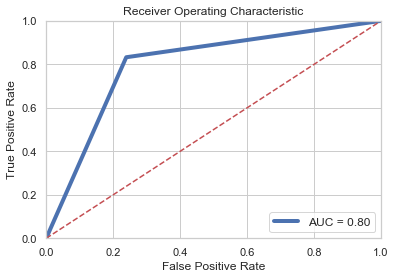

The sensitivity i.e true positives is 83.265857% 
The specificity i.e true negatives is 76.086957% 
The Type I error i.e. false negatives is 16.734143% 
The Type II error i.e. false positives is 23.913043% 


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [66]:
model(BernoulliNB())

In [67]:
### kNN Classifier

Model train score is 0.57

Cross_validation scores below :
 [0.5033557  0.50675676 0.52027027 0.50675676 0.52027027 0.5
 0.49659864 0.5170068  0.50340136 0.49659864]

Mean/test accuracy: 0.51 (+/- 0.02)



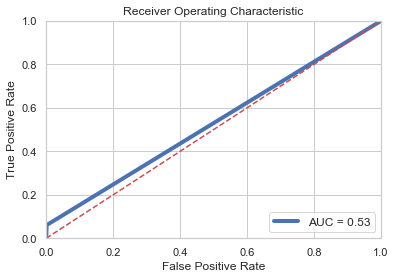

The sensitivity i.e true positives is 6.072874% 
The specificity i.e true negatives is 99.864130% 
The Type I error i.e. false negatives is 93.927126% 
The Type II error i.e. false positives is 0.135870% 


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [68]:
model(neighbors.KNeighborsClassifier(n_neighbors=5))

In [69]:
### Random Forest Classifier

C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model train score is 0.99

Cross_validation scores below :
 [0.66442953 0.76351351 0.75       0.70945946 0.68918919 0.64864865
 0.63945578 0.66666667 0.68027211 0.67346939]

Mean/test accuracy: 0.69 (+/- 0.08)



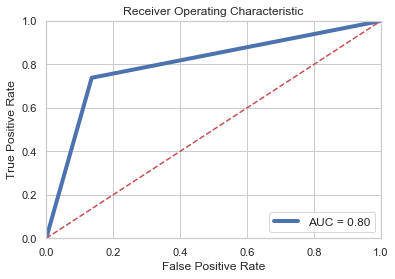

The sensitivity i.e true positives is 73.819163% 
The specificity i.e true negatives is 86.413043% 
The Type I error i.e. false negatives is 26.180837% 
The Type II error i.e. false positives is 13.586957% 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
model(ensemble.RandomForestClassifier())

In [71]:
### Gradient Boost Classifier

Model train score is 0.97

Cross_validation scores below :
 [0.80536913 0.83108108 0.81756757 0.77027027 0.7972973  0.83108108
 0.79591837 0.8707483  0.82312925 0.76190476]

Mean/test accuracy: 0.81 (+/- 0.06)



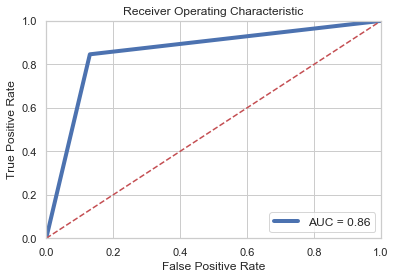

The sensitivity i.e true positives is 84.615385% 
The specificity i.e true negatives is 86.956522% 
The Type I error i.e. false negatives is 15.384615% 
The Type II error i.e. false positives is 13.043478% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [72]:
model(ensemble.GradientBoostingClassifier())

In [73]:
### Logistic Regression

Model train score is 0.93

Cross_validation scores below :
 [0.81208054 0.7972973  0.89864865 0.84459459 0.78378378 0.89864865
 0.84353741 0.8707483  0.81632653 0.82312925]

Mean/test accuracy: 0.84 (+/- 0.08)



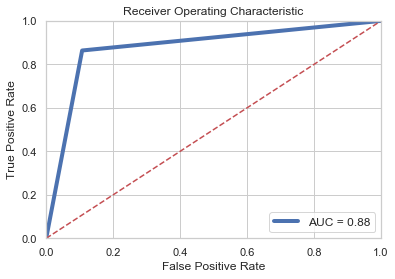

The sensitivity i.e true positives is 86.369771% 
The specificity i.e true negatives is 89.266304% 
The Type I error i.e. false negatives is 13.630229% 
The Type II error i.e. false positives is 10.733696% 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [74]:
model(LogisticRegression( solver='liblinear'))

### With TFIDF feature set : The Logistic regression gave the best AUC of 0.88.  84% test accuracy.

### With BOW feature set : The Gradient Boost classifier gave the best AUC of 0.67.  64% test accuracy.

### When compared with the BOW features and TF_IDF features, models generated from TF_IDF feature set gave much better results.

## 5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

In [75]:
### Gradient Boost Classifier

The default parameters are :
    GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

I have changed the following: and got 5% increase in accuracy from 82% to 87%.
    
params = {'learning_rate': 0.1, 'max_depth': 5,
          'max_features': 'sqrt','loss': 'deviance',
          'n_estimators': 1000}

In [76]:
### Gradient Boost Classifier

Model train score is 1.00

Cross_validation scores below :
 [0.86577181 0.87837838 0.89189189 0.87162162 0.83108108 0.83108108
 0.87755102 0.85714286 0.85034014 0.84353741]

Mean/test accuracy: 0.86 (+/- 0.04)



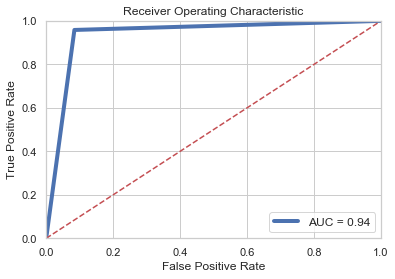

The sensitivity i.e true positives is 95.816464% 
The specificity i.e true negatives is 91.576087% 
The Type I error i.e. false negatives is 4.183536% 
The Type II error i.e. false positives is 8.423913% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [77]:
params = {'learning_rate': 0.1, 'max_depth': 5,
          'max_features': 'sqrt','loss': 'deviance',
          'n_estimators': 1000}

model(ensemble.GradientBoostingClassifier(**params))

To increase more I used GridSearchCV() GridSearch by cross validation by using the below code.
But it is taking a long time for the gridsearch.

In [ ]:
model_object = ensemble.GradientBoostingClassifier()
params = {
    "n_estimators":[50,250,500],
    "max_depth":[1,2, 3, 5],
    "learning_rate":[0.01,0.1,1]
}

from sklearn.model_selection import GridSearchCV
GSCV = GridSearchCV(model_object,params,cv=5)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
GSCV.fit(X_train, y_train)
print('Best parameters are: {}'.format(GSCV.best_params_))

The model can be enhanced even more using Neural networks and implement word2vec or sentence2vec or doc2vec embedding to generalize more.